<a href="https://colab.research.google.com/github/sahilsait/synthetic-EHR-data-generation/blob/main/CS271_final_project_evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, n_cont, latent_dim, hidden_dim=128):
        super().__init__()
        self.n_cont = n_cont
        self.n_cat  = input_dim - n_cont

        # Encoder
        self.fc1       = nn.Linear(input_dim, hidden_dim)
        self.fc_mu     = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Shared decoder body
        self.fc2       = nn.Linear(latent_dim, hidden_dim)

        # Continuous head (Gaussian)
        self.fc_cont_mu     = nn.Linear(hidden_dim, n_cont)
        self.fc_cont_logvar = nn.Linear(hidden_dim, n_cont)

        # Categorical head (Bernoulli per one‐hot slot)
        self.fc_cat_logits  = nn.Linear(hidden_dim, self.n_cat)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + std * torch.randn_like(std)

    def decode(self, z):
        h = F.relu(self.fc2(z))

        # Continuous reconstruction parameters
        mu_cont     = self.fc_cont_mu(h)
        logvar_cont = self.fc_cont_logvar(h)

        # Categorical logits
        logits_cat  = self.fc_cat_logits(h)

        return mu_cont, logvar_cont, logits_cat

    def forward(self, x):
        # encode
        mu_z, logvar_z = self.encode(x)
        z              = self.reparameterize(mu_z, logvar_z)
        # decode
        mu_cont, logvar_cont, logits_cat = self.decode(z)
        return mu_cont, logvar_cont, logits_cat, mu_z, logvar_z

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.cont_head = nn.Linear(hidden_dim, n_cont)
        self.cat_head  = nn.Linear(hidden_dim, n_cat)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        cont = self.cont_head(h)            # real-valued output
        cat  = torch.sigmoid(self.cat_head(h))  # [0,1] for one-hot
        return torch.cat([cont, cat], dim=1)

In [ ]:
class Diffusion(nn.Module):
    def __init__(self, input_dim, n_cont):
        super().__init__()
        self.n_cont = n_cont
        self.n_cat  = input_dim - n_cont

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        # two heads:
        self.cont_head = nn.Linear(128, n_cont)       # real outputs
        self.cat_head  = nn.Linear(128, self.n_cat)   # logits for one-hots

    def forward(self, x_noisy):
        h = self.net(x_noisy)
        cont_out = self.cont_head(h)            # unrestricted real
        cat_logits = self.cat_head(h)           # to sigmoid for probs
        return cont_out, cat_logits

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 152
n_cont = 5       # update with your actual value
n_cat  = 147     # input_dim - n_cont
hidden_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


vae = VAE(input_dim=input_dim, n_cont=n_cont, latent_dim=16)
latent_dim = 32
G = Generator()
diff = Diffusion(input_dim=input_dim, n_cont=n_cont)

vae.load_state_dict(torch.load('/content/drive/MyDrive/models/vae_best.pth'))
G.load_state_dict(torch.load('/content/drive/MyDrive/models/generator_weights.pth'))
diff.load_state_dict(torch.load('/content/drive/MyDrive/models/diffusion_best.pth'))


vae.eval()
G.eval()
diff.eval()

Diffusion(
  (net): Sequential(
    (0): Linear(in_features=152, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (cont_head): Linear(in_features=128, out_features=5, bias=True)
  (cat_head): Linear(in_features=128, out_features=147, bias=True)
)

In [ ]:
from scipy.sparse import load_npz

latent_dim = 16
def gen_vae(n, sample_cont=False):
    z = torch.randn(n, latent_dim, device=device)
    with torch.no_grad():
        mu_cont, logvar_cont, logits_cat = vae.decode(z)

        # Continuous features: either use the mean or sample from N(mu,σ²)
        if sample_cont:
            std = torch.exp(0.5 * logvar_cont)
            eps = torch.randn_like(std)
            cont_dec = mu_cont + eps * std
        else:
            cont_dec = mu_cont

        # Categorical features: probabilities via sigmoid
        cat_dec = torch.sigmoid(logits_cat)

        # Concatenate back to full feature vector
        x_dec = torch.cat([cont_dec, cat_dec], dim=1)

    return x_dec.cpu().numpy()

X = load_npz('/content/drive/MyDrive/datasets/X.npz')
n = X.shape[0]
s_vae  = gen_vae(n)

In [ ]:
latent_dim = 32
# Define a WGAN-GP generator helper
def gen_wgan(n):
    z = torch.randn(n, latent_dim, device=device)
    with torch.no_grad():
        # G already concatenates continuous + categorical heads
        return G(z).cpu().numpy()

noise_scale = 0.5

def gen_diff(n):
    # Sample noise and denoise
    noise = torch.randn(n, input_dim, device=device) * noise_scale
    with torch.no_grad():
        cont_pred, cat_logits = diff(noise)

        # Continuous features come straight out
        cont_dec = cont_pred

        # Categorical probabilities via sigmoid
        cat_dec  = torch.sigmoid(cat_logits)

        # Reassemble into full feature vector
        x_dec    = torch.cat([cont_dec, cat_dec], dim=1)

    return x_dec.cpu().numpy()

# now regenerate
X = load_npz('/content/drive/MyDrive/datasets/X.npz')
n = X.shape[0]
s_wgan = gen_wgan(n)
s_diff = gen_diff(n)

print(s_vae.shape, s_wgan.shape, s_diff.shape)  # should all be (8322, 152)

(8322, 152) (8322, 152) (8322, 152)


In [ ]:
import numpy as np
import pandas as pd
import joblib
from scipy.special import logit  # if you used sigmoid on numerics


preprocessor = joblib.load('/content/drive/MyDrive/datasets/preprocessor.pkl')
real_df = pd.read_csv('/content/drive/MyDrive/datasets/ehr_clean.csv')
numerical_cols = ['age','num_encounters','body_mass_index','heart_rate','systolic_blood_pressure']
categorical_cols = ['MARITAL','RACE','ETHNICITY','GENDER','last_encounter_type','DESCRIPTION']

# Extract the fitted sub-transformers:
num_scaler = preprocessor.named_transformers_['num']
ohe        = preprocessor.named_transformers_['cat']
# How many input dims each produced?
n_num      = len(numerical_cols)
cat_sizes  = [len(cats) for cats in ohe.categories_]  # e.g. [2,5,2,2,3,51]
# Cumulative splits for slicing
splits     = np.cumsum(cat_sizes)[:-1]

def array_to_df(synth_arr):
    """
    synth_arr: (n_samples, 152) array from VAE / GAN / Diffusion
    returns: DataFrame of shape (n_samples, 11) with original features
    """
    # 1) Numeric block
    num_block = synth_arr[:, :n_num]
    num_orig  = num_scaler.inverse_transform(num_block)

    # 2) Categorical block
    cat_block = synth_arr[:, n_num:]
    # Split into each feature’s one-hot subarray
    cat_splits = np.split(cat_block, splits, axis=1)
    decoded    = {}
    for i, cats in enumerate(ohe.categories_):
        # pick the most likely category
        idx      = cat_splits[i].argmax(axis=1)
        decoded[categorical_cols[i]] = np.array(cats)[idx]

    # 3) Build DataFrame
    df_s = pd.DataFrame(num_orig, columns=numerical_cols)
    for col in categorical_cols:
        df_s[col] = decoded[col]
    return df_s

# Example: convert your three sets
df_vae  = array_to_df(s_vae)
df_wgan  = array_to_df(s_wgan)
df_diff = array_to_df(s_diff)

Univariate KS-Statistic (Numerical)

In [ ]:
from scipy.stats import ks_2samp

def compute_ks(real_df, synth_df, numerical_cols):
    return {col: ks_2samp(real_df[col], synth_df[col]).statistic for col in numerical_cols}

ks_vae  = compute_ks(real_df, df_vae, numerical_cols)
ks_wgan = compute_ks(real_df, df_wgan, numerical_cols)
ks_diff = compute_ks(real_df, df_diff, numerical_cols)

In [ ]:
# Combine KS stats into a DataFrame
ks_df = pd.DataFrame({
    'VAE': ks_vae,
    'WGAN': ks_wgan,
    'Diffusion': ks_diff
}).T  # Transpose to make rows = models

# Show the table
ks_df

,age,num_encounters,body_mass_index,heart_rate,systolic_blood_pressure
VAE,0.057678,0.121966,0.192742,0.219539,0.197789
WGAN,0.070296,0.262557,0.199832,0.191901,0.056477
Diffusion,0.228431,0.342346,0.151286,0.296924,0.217856


Chi-Square Distance (Categorical)

In [ ]:
from scipy.stats import chisquare

def compute_chisq(real_df, synth_df, categorical_cols):
     results = {}
     for col in categorical_cols:
        # Get normalized frequency
        real_counts = real_df[col].value_counts(normalize=True).sort_index()
        synth_counts = synth_df[col].value_counts(normalize=True).sort_index()

        # Align category indexes
        combined_index = sorted(set(real_counts.index).union(synth_counts.index))
        real_vec = real_counts.reindex(combined_index, fill_value=0)
        synth_vec = synth_counts.reindex(combined_index, fill_value=0)

        # Filter out zero expected categories
        mask = real_vec > 0
        real_vec = real_vec[mask]
        synth_vec = synth_vec[mask]

        # If still empty after masking, skip
        if len(real_vec) == 0:
            results[col] = np.nan
            continue

        # Re-normalize both to sum to 1 (to satisfy chisquare)
        real_vec = real_vec / real_vec.sum()
        synth_vec = synth_vec / synth_vec.sum() if synth_vec.sum() > 0 else np.full_like(real_vec, 1 / len(real_vec))

        # Compute chi-square
        try:
            stat, _ = chisquare(f_obs=synth_vec, f_exp=real_vec)
            results[col] = stat
        except:
            results[col] = np.nan  # fallback
     return results

chisq_vae  = compute_chisq(real_df, df_vae, categorical_cols)
chisq_wgan = compute_chisq(real_df, df_wgan, categorical_cols)
chisq_diff = compute_chisq(real_df, df_diff, categorical_cols)

chisq_df = pd.DataFrame({
    'VAE': chisq_vae,
    'WGAN': chisq_wgan,
    'Diffusion': chisq_diff
}).T  # Transpose to make rows = models

# Show the table
chisq_df

,MARITAL,RACE,ETHNICITY,GENDER,last_encounter_type,DESCRIPTION
VAE,0.400324,14.785339,2.070916,0.000914,0.023255,1.533621
WGAN,0.400324,14.785339,2.070916,0.003986,0.015587,0.207159
Diffusion,0.400324,14.785339,2.070916,0.003986,0.067553,0.678137


Correlation Matrix Difference

In [ ]:
def correlation_diff(real_df, synth_df, numerical_cols):
    corr_real = real_df[numerical_cols].corr().values
    corr_synth = synth_df[numerical_cols].corr().values
    return np.linalg.norm(corr_real - corr_synth, ord='fro')  # Frobenius norm

corr_diff_vae  = correlation_diff(real_df, df_vae, numerical_cols)
corr_diff_wgan = correlation_diff(real_df, df_wgan, numerical_cols)
corr_diff_diff = correlation_diff(real_df, df_diff, numerical_cols)


# Combine KS stats into a DataFrame
corr_diff_df = pd.DataFrame({
    'VAE': [corr_diff_vae],
    'WGAN': [corr_diff_wgan],
    'Diffusion': [corr_diff_diff]
}).T

# Show the table
corr_diff_df

,0
VAE,0.806106
WGAN,0.155923
Diffusion,0.476165


 Wasserstein Distance (Categorical)

In [ ]:
from scipy.stats import wasserstein_distance

def compute_wasserstein_cat(real_df, synth_df, categorical_cols):
    wdist = {}
    for col in categorical_cols:
        # make sure both Series use the same ordered categories
        # (so codes line up)
        cats = real_df[col].astype('category').cat.categories.union(
               synth_df[col].astype('category').cat.categories)
        real_codes = real_df[col].astype(pd.CategoricalDtype(cats)).cat.codes
        synth_codes = synth_df[col].astype(pd.CategoricalDtype(cats)).cat.codes

        # now compute 1D EMD where adjacent codes are distance=1
        wdist[col] = wasserstein_distance(real_codes, synth_codes)
    return wdist

wasserstein_vae  = compute_wasserstein_cat(real_df, df_vae, categorical_cols)
wasserstein_wgan = compute_wasserstein_cat(real_df, df_wgan, categorical_cols)
wasserstein_diff = compute_wasserstein_cat(real_df, df_diff, categorical_cols)

# turn into a nice DataFrame
wasserstein_df = pd.DataFrame({
    'VAE': wasserstein_vae,
    'WGAN': wasserstein_wgan,
    'Diffusion': wasserstein_diff
}).T

print(wasserstein_df)

            MARITAL      RACE  ETHNICITY    GENDER  last_encounter_type  \
VAE        5.061404  2.109589   3.348474  0.015020             0.148161   
WGAN       5.813747  2.065129   3.335136  0.031363             0.169911   
Diffusion  5.111632  1.942802   3.380437  0.031363             0.239726   

           DESCRIPTION  
VAE          23.011896  
WGAN          2.357967  
Diffusion    10.473564  


Nearest-Neighbor L2 Distance

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

def compute_privacy(real_df, synth_df, numerical_cols, categorical_cols):
    # Encode categorical columns numerically for distance
    real_enc = pd.get_dummies(real_df[categorical_cols])
    synth_enc = pd.get_dummies(synth_df[categorical_cols])
    # Align columns
    combined_cols = sorted(set(real_enc.columns).union(synth_enc.columns))
    real_enc = real_enc.reindex(columns=combined_cols, fill_value=0)
    synth_enc = synth_enc.reindex(columns=combined_cols, fill_value=0)

    real_num = real_df[numerical_cols].values
    synth_num = synth_df[numerical_cols].values

    # Normalize numerics for fair distance
    scaler = StandardScaler().fit(real_num)
    real_num = scaler.transform(real_num)
    synth_num = scaler.transform(synth_num)

    real_vecs = np.hstack([real_num, real_enc.values])
    synth_vecs = np.hstack([synth_num, synth_enc.values])

    dists = euclidean_distances(synth_vecs, real_vecs)
    min_dists = dists.min(axis=1)
    return min_dists

priv_vae  = compute_privacy(real_df, df_vae, numerical_cols, categorical_cols)
priv_wgan = compute_privacy(real_df, df_wgan, numerical_cols, categorical_cols)
priv_diff = compute_privacy(real_df, df_diff, numerical_cols, categorical_cols)

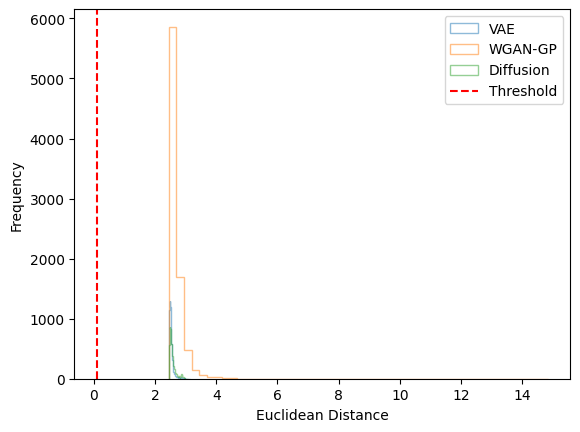

In [ ]:
import matplotlib.pyplot as plt

#Minimum Distance from Synthetic to Real Records

plt.hist(priv_vae, bins=50, alpha=0.5, histtype='step', label='VAE')
plt.hist(priv_wgan, bins=50, alpha=0.5, histtype='step', label='WGAN-GP')
plt.hist(priv_diff, bins=50, alpha=0.5, histtype='step', label='Diffusion')
plt.axvline(0.1, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.show()

In [ ]:
print("Average minimum distance from synthetic to real data:")
print(f"VAE:       {np.mean(priv_vae):.4f}")
print(f"WGAN:      {np.mean(priv_wgan):.4f}")
print(f"Diffusion: {np.mean(priv_diff):.4f}")


Average minimum distance from synthetic to real data:
VAE:       2.5265
WGAN:      2.6728
Diffusion: 2.5644


In [ ]:
print("Median minimum distance:")
print(f"VAE:       {np.median(priv_vae):.4f}")
print(f"WGAN:      {np.median(priv_wgan):.4f}")
print(f"Diffusion: {np.median(priv_diff):.4f}")


Median minimum distance:
VAE:       2.5065
WGAN:      2.5837
Diffusion: 2.5300
